In [987]:
import pandas as pd
# pd.options.display.max_rows = None
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [988]:
df_train = pd.read_csv('../data/iith_foml_2023_train.csv')
df_corr = df_train.corr()
drop_cols = ['Feature 3 (Discrete)', 'Feature 10', 'Feature 14', 'Feature 16', 'Feature 17', 'Feature 23 (Discrete)']
# display(df_corr.where(df_corr > 0.75))
df_train.drop(columns=drop_cols, inplace=True)
# for column in df_train.columns:
#     if df_train[column].isna().any():
#         mean_value = df_train[column].mode()[0]
#         df_train[column].fillna(mean_value, inplace=True)
df_train.fillna(1e9, inplace=True)


In [989]:
class_counts = df_train["Target Variable (Discrete)"].value_counts()
print(class_counts)


Target Variable (Discrete)
1     488
0     249
2     109
6      70
5      41
8       7
14      5
7       5
15      4
4       3
13      3
3       3
9       2
12      1
17      1
11      1
10      1
16      1
Name: count, dtype: int64


In [990]:
import numpy as np
import pandas as pd

# Assuming class_counts is defined somewhere in your code
minority_classes = class_counts[class_counts < 50].index

df_oversampled = pd.DataFrame()

for cls in minority_classes:
    minority_instances = df_train[df_train["Target Variable (Discrete)"] == cls]
    oversampled_instances = minority_instances.sample(n=40, replace=True, random_state=42)

    # Add Gaussian noise
    noise = np.random.normal(loc=0, scale=0.1, size=oversampled_instances.shape)
    oversampled_instances_with_noise = oversampled_instances + noise


    df_oversampled = pd.concat([df_oversampled, oversampled_instances_with_noise])
    
df_oversampled["Target Variable (Discrete)"] = df_oversampled["Target Variable (Discrete)"].round()
print(df_oversampled["Target Variable (Discrete)"].value_counts())


Target Variable (Discrete)
5.0     40
8.0     40
14.0    40
7.0     40
15.0    40
4.0     40
13.0    40
3.0     40
9.0     40
12.0    40
17.0    40
11.0    40
10.0    40
16.0    40
Name: count, dtype: int64


In [991]:
# Assuming df_train is your original dataframe
from imblearn.over_sampling import SMOTE

# Separate majority and minority classes in df_train
majority_instances = df_train[df_train["Target Variable (Discrete)"].isin(minority_classes) == False]

majority_instances = df_train[df_train["Target Variable (Discrete)"].isin(minority_classes) == False]
df_train_updated = pd.concat([majority_instances, df_oversampled], ignore_index=True)


# Check the distribution of classes in the updated DataFrame
print(df_train_updated["Target Variable (Discrete)"].value_counts())


Target Variable (Discrete)
1.0     488
0.0     249
2.0     109
6.0      70
3.0      40
10.0     40
11.0     40
17.0     40
12.0     40
9.0      40
4.0      40
13.0     40
15.0     40
7.0      40
14.0     40
8.0      40
5.0      40
16.0     40
Name: count, dtype: int64


In [992]:
X = df_train_updated.iloc[:, :-1]
y = df_train_updated.iloc[:, -1]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [993]:
X_train, val_x, y_train, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [994]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [995]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import XGBClassifier

def report_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro', zero_division=0.0)

model = KNeighborsClassifier(n_neighbors=7, n_jobs=-1, weights='distance')
# model = XGBClassifier()

cv_f1_score = cross_val_score(model, X_train_resampled, y_train_resampled, scoring=make_scorer(report_f1))
print(cv_f1_score)

model.fit(X_train, y_train)

[0.9753851  0.9822448  0.97777892 0.98301351 0.98831881]


KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

In [996]:
y_val_pred = model.predict(val_x)
macro_f1 = f1_score(val_y, y_val_pred, average='macro')

print(f'Macro F1 Score: {macro_f1}')

Macro F1 Score: 0.8688141203168573


In [997]:
cv_f1_score = cross_val_score(model, X_train, y_train, scoring=make_scorer(report_f1))
print(cv_f1_score)

[0.87372926 0.91149723 0.88758871 0.87061798 0.85823158]


In [998]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

dt_classification_rep = classification_report(val_y, y_val_pred, zero_division=0.0)
print("\n Classification Report:\n", dt_classification_rep)


 Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        43
         1.0       0.94      0.89      0.92       104
         2.0       0.72      0.46      0.57        28
         3.0       0.62      1.00      0.77        10
         4.0       1.00      1.00      1.00        12
         5.0       0.80      0.31      0.44        13
         6.0       0.93      1.00      0.97        14
         7.0       0.69      1.00      0.82         9
         8.0       1.00      1.00      1.00         7
         9.0       1.00      1.00      1.00         4
        10.0       0.86      1.00      0.92         6
        11.0       1.00      1.00      1.00         4
        12.0       1.00      1.00      1.00         3
        13.0       0.75      1.00      0.86         9
        14.0       0.80      1.00      0.89         8
        15.0       0.54      1.00      0.70         7
        16.0       1.00      1.00      1.00         9
 

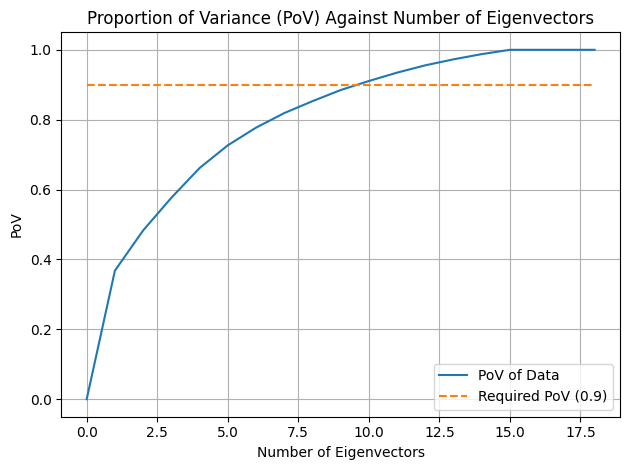

In [999]:
from sklearn.decomposition import PCA
full_pca = PCA()
X_pca = full_pca.fit_transform(X)
# PoV array (zero padded at the start)
cumulative_variance = np.zeros(len(full_pca.explained_variance_ratio_) + 1)
cumulative_variance[1:] = np.cumsum(full_pca.explained_variance_ratio_)

# Plot the cumulative variance as well as cutoff 0.9 PoV
plt.plot(cumulative_variance)
plt.plot(np.arange(cumulative_variance.shape[0]), 0.9*np.ones_like(cumulative_variance), '--')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('PoV')
plt.title('Proportion of Variance (PoV) Against Number of Eigenvectors')
plt.legend(['PoV of Data', 'Required PoV (0.9)'])
plt.grid()
plt.tight_layout()
plt.show()

In [1000]:
pca_comp = np.searchsorted(cumulative_variance, 0.9)
pca_comp

10